In [ ]:
## importing Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

#Modules related to split the data & gridsearch
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#Modules related to preprocessing (Imputation of missings, standardiszation, new features creation, converting categorical to numerical)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE

#Moudles related to feature selection
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif

#Module related to calculation of metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Importing logger for logging information
#from Info_logger import logging

#Modules related key techniques of supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [ ]:
# Mounting Colab notebook with Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Setting up the Dataset path
dataset_path = '/content/drive/MyDrive/PW Internship/Phishing Domain Detection'

In [ ]:
## Impoting the necessary Datasets
dataset = pd.read_csv(dataset_path+'/dataset_small.csv',index_col=None)

In [ ]:
dataset

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3598,0,0,0,0,0,0
1,4,0,0,2,0,0,0,0,0,0,...,1,4,1,3977,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,1,2,1,10788,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,...,1,2,1,14339,1,0,0,0,0,1
4,1,1,0,4,0,0,0,0,0,0,...,1,2,1,389,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,1,0,0,5,0,1,0,0,0,0,...,1,2,2,563,0,0,0,0,0,1
58641,2,0,0,0,0,0,0,0,0,0,...,1,4,0,122,1,0,0,0,0,0
58642,5,6,3,6,0,2,1,1,0,0,...,1,2,1,1122,0,0,0,0,0,1
58643,2,0,0,0,0,0,0,0,0,0,...,5,2,5,299,1,1,0,0,0,0


In [ ]:
dataset.isnull().sum()

qty_dot_url             0
qty_hyphen_url          0
qty_underline_url       0
qty_slash_url           0
qty_questionmark_url    0
                       ..
qty_redirects           0
url_google_index        0
domain_google_index     0
url_shortened           0
phishing                0
Length: 112, dtype: int64

In [ ]:
## Dividing X and Y variables
X_1 = pd.DataFrame(dataset.drop(columns="phishing"))
Y = pd.DataFrame(dataset["phishing"])

In [ ]:
def treat_outliers(df, lower_quantile=0.01, upper_quantile=0.99):


    treated_df = pd.DataFrame()

    for column in df.columns:
        lower_threshold = df[column].quantile(lower_quantile)
        upper_threshold = df[column].quantile(upper_quantile)

        treated_column = df[column].clip(lower_threshold, upper_threshold)
        treated_df[column] = treated_column

    return treated_df

## Function to treat missing values
def Null_treatment(x):
    for col in x.columns:
        if x[col].dtype == 'object':
         x[col].fillna(x[col].mode()[0],inplace=True)
        else:
           x[col].fillna(x[col].median(),inplace=True)
    return(x)

    ## Below function will be used to drop Variables with std_dev 0 as those variable wont contribute much in predictions
def get_cols_with_zero_std_dev(df: pd.DataFrame):
    """
    Returns a list of columns names which are having zero standard deviation.
    """
    cols_to_drop = []
    num_cols = [col for col in df.columns if df[col].dtype != 'O']  # numerical cols only
    for col in num_cols:
        if df[col].std() == 0:
            cols_to_drop.append(col)
    return df.drop(columns=cols_to_drop)

In [ ]:
## Treating the missing values
Null_treatment(X_1)

In [ ]:
## Removing columns with 0 std as it wont contribute to analysis
X_1 = get_cols_with_zero_std_dev(X_1)

In [ ]:
X_1

In [ ]:
## Creating a correlation plot to check multicolinearity
plt.figure(figsize=(35,25))
sns.heatmap(data=X_1.corr(),annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

"""

From the below Heatmap it can be clearly seen that there are multiple columns which are highly colinear with other columns,
So need to drop those coulmns to get rid off of the issue of multicolinearity.

"""

In [ ]:
# Calculate the correlation matrix
corr_matrix = X_1.corr().abs()

# Create a boolean mask to identify columns with correlation greater than 0.90
high_corr_cols = np.full(corr_matrix.shape, False, dtype=bool)
high_corr_cols[np.triu_indices(len(high_corr_cols), k=1)] = corr_matrix.values[np.triu_indices(len(corr_matrix), k=1)] > 0.90

# Get the column indices to drop
cols_to_drop = np.where(high_corr_cols.any(axis=0))[0]

# Drop the columns from the DataFrame
X_1.drop(X_1.columns[cols_to_drop], axis=1, inplace=True)

In [ ]:
## Creating a correlation plot to check multicolinearity
plt.figure(figsize=(35,25))
sns.heatmap(data=X_1.corr(),annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

"""

From the below Heatmap it can be clearly seen that there are multiple columns which are highly colinear with other columns,
So need to drop those coulmns to get rid off of the issue of multicolinearity.

"""

In [ ]:
## Splitting the dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X_1, Y, test_size=0.2, random_state=42)

print(f"train set: {X_train.shape, y_train.shape}")
print(f"test set: {X_test.shape, y_test.shape}")

train set: ((46916, 60), (46916, 1))
test set: ((11729, 60), (11729, 1))


### Feature Selection

#### checking the contribution of each feature

#### Feature Importance from Tree-based Models

In [ ]:
# Create a RandomForestClassifier model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Calculate the cumulative sum of feature importances
cumulative_importance = feature_importance_df['Importance'].cumsum()

# Find the index where cumulative importance exceeds or reaches 90%
selected_features_idx = (cumulative_importance <= 0.95).sum()

# Select the top features up to that index
selected_features = feature_importance_df.iloc[:selected_features_idx + 1]['Feature']

# Print the selected feature names
#print(selected_features)



#### Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE

## Finding Top important features using RFE
model = LogisticRegression()

rfe = RFE(estimator=model, n_features_to_select=40)

rfe = rfe.fit(X_train, y_train)

imp_vars_RFE = list(X_train.columns[rfe.support_])


In [ ]:
# Assuming selected_features is a set
selected_features = set(selected_features)

# Assuming imp_vars_RFE is a set or list
imp_vars_RFE = set(imp_vars_RFE)

# Create a set that combines both sets
combined_features_set = selected_features.intersection(imp_vars_RFE)

list(combined_features_set)


In [ ]:
x_train = X_train[combined_features_set]

x_test = X_test[combined_features_set]

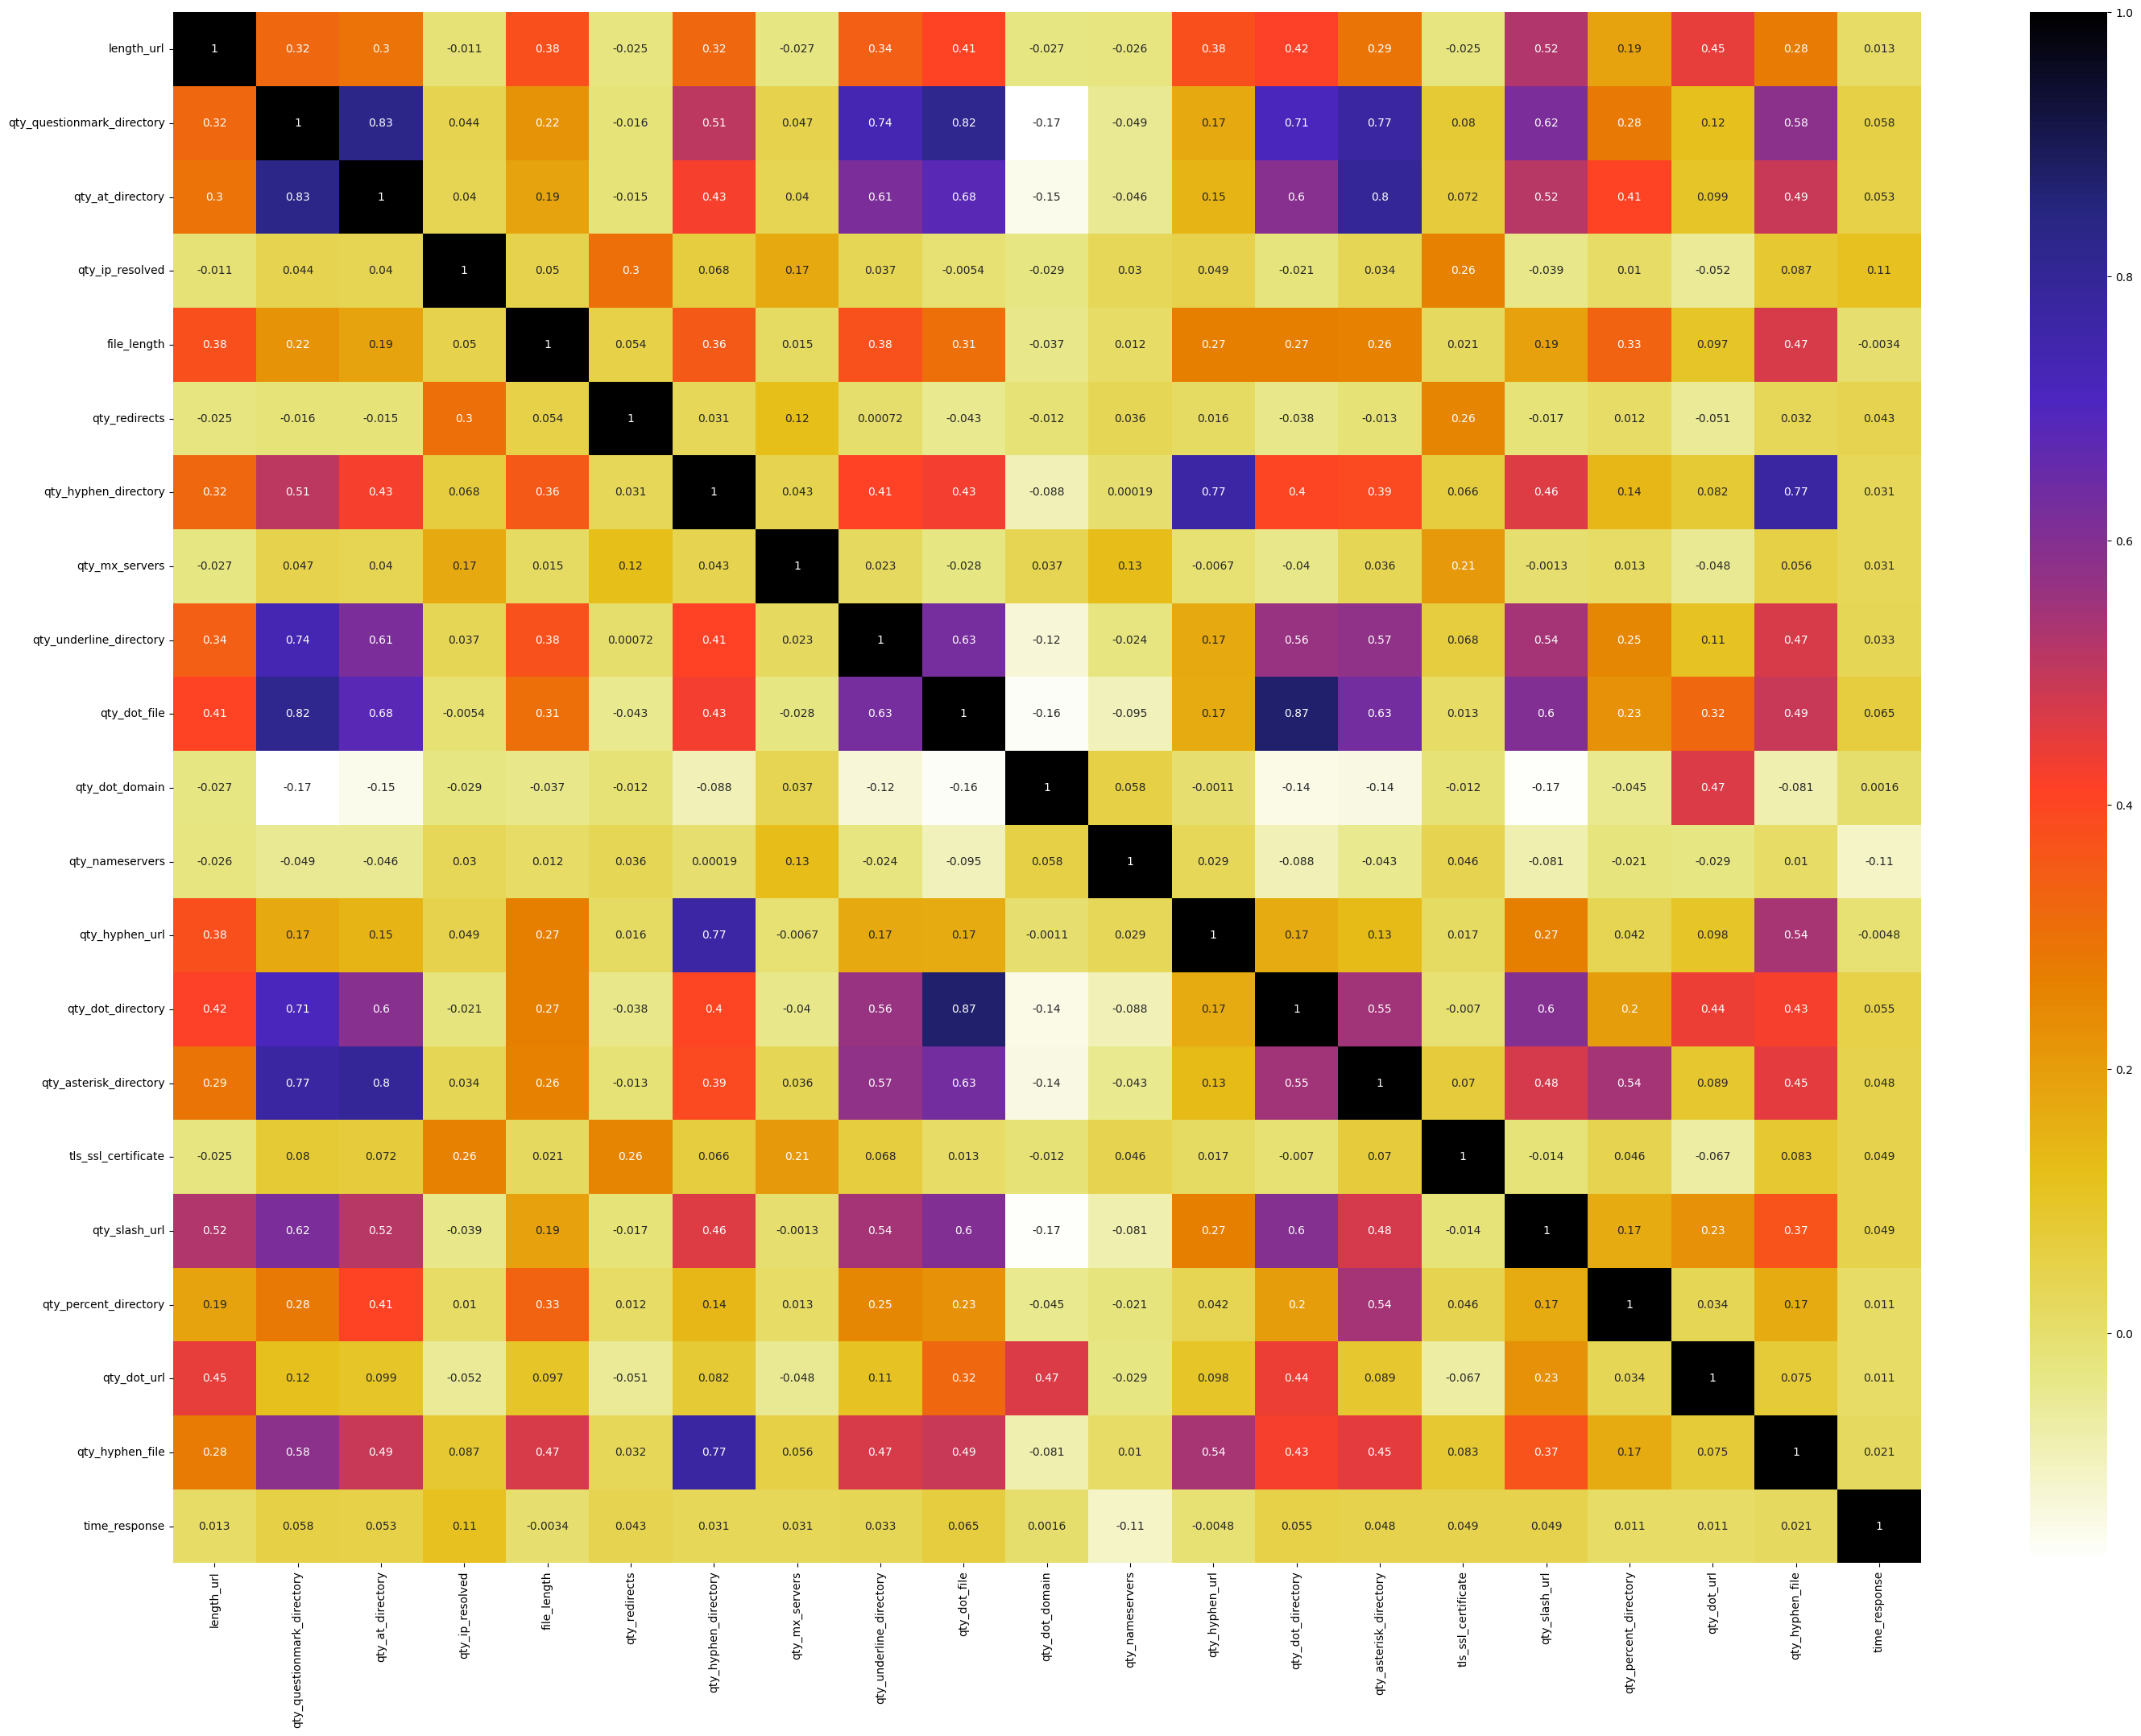

In [ ]:
## Creating a correlation plot to check multicolinearity in final data set
plt.figure(figsize=(35,25))
sns.heatmap(data=x_train.corr(),annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
# Define the column names
cols = list(x_train.columns)


# Create the preprocessing steps for numerical columns
transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), ## imputing missing values if found any
    ('scaler', StandardScaler()) ## scaling up the data using standard scaler
])



# Create the column transformer
preprocessor_X = ColumnTransformer(transformers=[
    ('num', transformer, cols)
])



# Apply the preprocessing pipeline to Train_X and Test_X
X_train_sc = pd.DataFrame(preprocessor_X.fit_transform(x_train),columns=preprocessor_X.get_feature_names_out())
X_test_sc = pd.DataFrame(preprocessor_X.transform(x_test),columns=preprocessor_X.get_feature_names_out())

In [ ]:
## Creating a list of models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    XGBClassifier(),
    SVC(),
    RandomForestClassifier(random_state=42)
]


# Perform cross-validation and get the scores for each model
for model in models:
    scores = cross_val_score(model, X_train_sc, y_train, cv=5)
    print("Model:", type(model).__name__)
    print("Scores:", scores)
    print("Average Score:", scores.mean())
    print()

Model: LogisticRegression
Scores: [0.85421995 0.86145156 0.85686881 0.85548332 0.85942662]
Average Score: 0.8574900517968912

Model: DecisionTreeClassifier
Scores: [0.8920503  0.8889481  0.89214537 0.88926782 0.89235852]
Average Score: 0.8909540221613902

Model: XGBClassifier
Scores: [0.92369991 0.91953533 0.92017478 0.91846957 0.92539699]
Average Score: 0.9214553191961047

Model: SVC
Scores: [0.88384484 0.88852179 0.8862837  0.88329958 0.88766919]
Average Score: 0.8859238229810874

Model: RandomForestClassifier
Scores: [0.9273231  0.9266759  0.92561015 0.92507727 0.92646275]
Average Score: 0.9262298343151837



In [ ]:
## Initializing Random Forest model
RF_class = RandomForestClassifier(random_state=42)

## Training the model
RF_class.fit(X_train_sc,y_train)

## Predicting for Train & Test dataset
train_pred_RF = RF_class.predict(X_train_sc)
test_pred_RF = RF_class.predict(X_test_sc)

## Printing classification report for Train & Test
print(classification_report(y_train, train_pred_RF))
print(classification_report(y_test, test_pred_RF))

## Calculating ROC_AUC Score
train_auc = roc_auc_score(y_train['phishing'],train_pred_RF)
test_auc = roc_auc_score(y_test['phishing'], test_pred_RF)

## Printing ROC_AUC Score for Train & Test
print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22402
           1       1.00      1.00      1.00     24514

    accuracy                           1.00     46916
   macro avg       1.00      1.00      1.00     46916
weighted avg       1.00      1.00      1.00     46916

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5596
           1       0.93      0.93      0.93      6133

    accuracy                           0.93     11729
   macro avg       0.93      0.93      0.93     11729
weighted avg       0.93      0.93      0.93     11729

The AUC for the model built on the Train Data is :  0.9988824494444658
The AUC for the model built on the Test Data is :  0.9285146607829519


In [ ]:
## Initializing Random Forest model
RF_class = XGBClassifier()

## Training the model
RF_class.fit(X_train_sc,y_train)

## Predicting for Train & Test dataset
train_pred_RF = RF_class.predict(X_train_sc)
test_pred_RF = RF_class.predict(X_test_sc)

## Printing classification report for Train & Test
print(classification_report(y_train, train_pred_RF))
print(classification_report(y_test, test_pred_RF))

## Calculating ROC_AUC Score
train_auc = roc_auc_score(y_train['phishing'],train_pred_RF)
test_auc = roc_auc_score(y_test['phishing'], test_pred_RF)

## Printing ROC_AUC Score for Train & Test
print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     22402
           1       0.95      0.94      0.94     24514

    accuracy                           0.94     46916
   macro avg       0.94      0.94      0.94     46916
weighted avg       0.94      0.94      0.94     46916

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      5596
           1       0.93      0.92      0.92      6133

    accuracy                           0.92     11729
   macro avg       0.92      0.92      0.92     11729
weighted avg       0.92      0.92      0.92     11729

The AUC for the model built on the Train Data is :  0.9407247628656916
The AUC for the model built on the Test Data is :  0.9193791989036916
